# Nowcasting UK GDP

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import math
from math import sqrt 

StatementMeta(, 02df3cdc-b84e-4ef5-9c00-71b233ab8183, 17, Finished, Available, Finished)

In [ ]:
# read in the xlsx file.
# import pandas as pd 
# file_path = 'abfss://gdp2@onelake.dfs.fabric.microsoft.com/dataforgdp.Lakehouse/Files/df_tidy.xlsx'
# df_tidy_2 = pd.read_excel(file_path, sheet_name='df_tidy', engine='openpyxl') 

StatementMeta(, 02df3cdc-b84e-4ef5-9c00-71b233ab8183, 23, Finished, Available, Finished)

In [44]:
file_path = 'abfss://gdp2@onelake.dfs.fabric.microsoft.com/dataforgdp.Lakehouse/Files/zac_augmented.csv'
df_tidy = pd.read_csv(file_path)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 46, Finished, Available, Finished)

In [45]:
# Assuming 'df_tidy' is your DataFrame, 'target' is the name of your target variable column, 
# and 'data_type' is the column that specifies whether the row is for training or testing

# Splitting the DataFrame into training and testing based on 'data_type'
train_df = df_tidy[df_tidy['data_type'] == 'train']
test_df = df_tidy[df_tidy['data_type'] == 'test']

# train_df.loc[:, 'y'] = train_df['y'].shift(-2)  
# train_df = train_df.iloc[:-2]  # Drop last row (now has NaN in 'y')

# test_df.loc[:, 'y'] = test_df['y'].shift(-2)
# test_df = test_df.iloc[:-2]

# Now, separating features and target for both training and testing sets
X_train = train_df.drop(['y', 'data_type', 'date'], axis=1)  # Drops target and data_type columns from the training set
y_train = train_df['y']

X_test = test_df.drop(['y', 'data_type', 'date'], axis=1)    # Drops target and data_type columns from the testing set
y_test = test_df['y']

features = [col for col in X_train.columns]

# Your datasets are now ready to be used for model training and evaluation

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 47, Finished, Available, Finished)

## Feature engineering

In [ ]:
df_current_train = dfs['df_current_train'] 
df_current_test = dfs['df_current_test'] 
df_1ahead_train = dfs['df_1ahead_train'] 
df_1ahead_test = dfs['df_1ahead_test'] 
df_2ahead_train = dfs['df_2ahead_train'] 
df_2ahead_test = dfs['df_2ahead_test'] 

In [ ]:
df_train = df_current_train.copy()
df_test = df_current_test.copy()
df_train = df_train.drop(columns=["y_lag"])
df_test = df_test.drop(columns=["y"])

df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Shift 'y' and 'date' up by one
df_train['y'] = df_train['y'].shift(-1)
df_test['y'] = df_test['y_lag'].shift(-2)
df_train['date'] = df_train['date'].shift(-1)
df_test['date'] = df_test['date'].shift(-1)

StatementMeta(, c5b1e39b-5622-4d44-8895-46f2205c9423, 9, Finished, Available, Finished)

NameError: name 'df_current_train' is not defined

In [16]:
# Step 1: Interpolate missing values for 'awe'
df_train["awe"] = df_train["awe"].interpolate(method="linear")
df_train["visa"] = df_train["visa"].interpolate(method="linear")

# Step 2: Backfill 'oil_pl' and 'loans' using .bfill() instead of fillna()
df_train["oil_pl"] = df_train["oil_pl"].bfill()
df_train["loans"] = df_train["loans"].fillna(df_train["loans"].mean())

# Step 3: Remove 'net_lend' column if it exists
if "net_lend" in df_train.columns:
    df_train.drop(columns=["net_lend"], inplace=True)

# Step 1: Interpolate missing values for 'awe' and 'visa'
df_test["awe"] = df_test["awe"].interpolate(method="linear")
df_test["visa"] = df_test["visa"].interpolate(method="linear")

# Step 2: Backfill 'oil_pl' and 'loans' using .bfill()
df_test["oil_pl"] = df_test["oil_pl"].bfill()
df_test["loans"] = df_test["loans"].fillna(df_test["loans"].mean())

# Step 3: Remove 'net_lend' column if it exists
if "net_lend" in df_test.columns:
    df_test.drop(columns=["net_lend"], inplace=True)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 18, Finished, Available, Finished)

In [17]:
# df_train cleaning
columns_to_lag = [
    'cpi', 'm4', 'm4_lend', 'loans', 'br', 'gscpi',
    'GBP/US', 'GBP/EU', 'unemply', 'awe', 'oil_pl','us_gdp', 'eu_gdp',
    'sr', 'imp', 'exp', 'expp', 'pop', 'visa', 'A_MoM', 'A_QoQ', 'B_MoM',
    'BE_MoM', 'BE_QoQ', 'C_MoM', 'C_QoQ', 'D_MoM', 'E_MoM', 'F_MoM',
    'F_QoQ', 'G_MoM', 'GT_MoM', 'GT_QoQ', 'GVA_MoM', 'H_MoM', 'I_MoM',
    'IOS_MoM', 'IOP_MoM', 'J_MoM', 'K_MoM', 'L_MoM', 'M_MoM', 'O_MoM',
    'N_MoM', 'P_MoM', 'P3G_QoQ', 'P3H_QoQ', 'P3N_QoQ', 'P51_QoQ',
    'P51S_QoQ', 'P6_QoQ', 'P7_QoQ', 'Q_MoM', 'R_MoM', 'S_MoM', 'T_MoM'
]

# Create a new DataFrame to store lagged columns
lagged_columns = {}

for col in columns_to_lag:
    lagged_columns[f"{col}_lag1"] = df_train[col].shift(1)  # Shift by 1 row
    lagged_columns[f"{col}_lag2"] = df_train[col].shift(2)  # Shift by 2 rows

# Concatenate lagged columns to the original DataFrame at once (avoiding fragmentation)
df_train = pd.concat([df_train, pd.DataFrame(lagged_columns)], axis=1)
df_train = df_train.dropna(subset=['y'])
selected_columns = df_train[['date', 'y','cpi', 'cpi_lag1', 'cpi_lag2']]
selected_columns.head(10)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 19, Finished, Available, Finished)

,date,y,cpi,cpi_lag1,cpi_lag2
1,1998-03-01,0.7,70.254,NaN,NaN
4,1998-06-01,0.8,71.072,70.700,70.498
7,1998-09-01,0.7,70.952,71.343,71.449
10,1998-12-01,0.9,71.534,71.548,71.238
13,1999-03-01,0.5,71.367,71.808,71.590
16,1999-06-01,0.0,72.168,71.880,71.489
19,1999-09-01,1.7,71.877,72.306,72.382
22,1999-12-01,1.3,72.330,72.387,72.097
25,2000-03-01,0.8,71.936,72.615,72.435
28,2000-06-01,0.5,72.573,72.338,72.159


In [18]:
# Create a new DataFrame to store lagged columns
lagged_columns1 = {}

for col in columns_to_lag:
    lagged_columns1[f"{col}_lag1"] = df_test[col].shift(1)  # Shift by 1 row
    lagged_columns1[f"{col}_lag2"] = df_test[col].shift(2)  # Shift by 2 rows

# Concatenate lagged columns to the original DataFrame at once (avoiding fragmentation)
df_test = pd.concat([df_test, pd.DataFrame(lagged_columns1)], axis=1)
df_test = df_test.dropna(subset=['y'])
selected_columns = df_test[['date', 'y','cpi', 'cpi_lag1', 'cpi_lag2']]
selected_columns.head(10)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 20, Finished, Available, Finished)

,date,y,cpi,cpi_lag1,cpi_lag2
1,1998-03-01,0.7,70.254,NaN,NaN
4,1998-06-01,0.8,71.072,70.700,70.498
7,1998-09-01,0.7,70.952,71.343,71.449
10,1998-12-01,0.9,71.534,71.548,71.238
13,1999-03-01,0.5,71.367,71.808,71.590
16,1999-06-01,0.0,72.168,71.880,71.489
19,1999-09-01,1.7,71.877,72.306,72.382
22,1999-12-01,1.3,72.330,72.387,72.097
25,2000-03-01,0.8,71.936,72.615,72.435
28,2000-06-01,0.5,72.573,72.338,72.159


In [19]:
# Define columns for which we keep only the `_lag1` versions
columns_to_lag = [
    'us_gdp', 'eu_gdp', 'sr', 'imp', 'exp', 'expp', 'pop', 'A_QoQ',  
    'BE_QoQ', 'C_QoQ', 'F_QoQ', 'GT_QoQ', 'P3G_QoQ', 'P3H_QoQ', 'P3N_QoQ', 
    'P51_QoQ', 'P51S_QoQ', 'P6_QoQ', 'P7_QoQ','visa'
]

# Identify all columns to drop (original versions & `_lag2` versions of selected columns)
columns_to_drop = columns_to_lag + [f"{col}_lag2" for col in columns_to_lag]

# Keep all other columns + only `_lag1` versions of the specified columns
columns_to_keep = [col for col in df_train.columns if col not in columns_to_drop]

# Ensure it's a new copy to avoid warnings
df_train_filtered = df_train[columns_to_keep].copy()

# Rename '_lag1' columns back to their original names
df_train_filtered = df_train_filtered.rename(columns={f"{col}_lag1": col for col in columns_to_lag})


# Ensure it's a new copy to avoid warnings
df_test_filtered = df_test[columns_to_keep].copy()

# Rename '_lag1' columns back to their original names
df_test_filtered = df_test_filtered.rename(columns={f"{col}_lag1": col for col in columns_to_lag})


StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 21, Finished, Available, Finished)

In [20]:
df_train_filtered.fillna(df_train_filtered.median(), inplace=True)
df_train = df_train_filtered.copy()
df_test_filtered.fillna(df_test_filtered.median(), inplace=True)
df_test = df_test_filtered.copy()
df_train.head(10)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 22, Finished, Available, Finished)

,date,y,cpi,m4,m4_lend,loans,br,gscpi,GBP/US,GBP/EU,...,P6_QoQ,P7_QoQ,Q_MoM_lag1,Q_MoM_lag2,R_MoM_lag1,R_MoM_lag2,S_MoM_lag1,S_MoM_lag2,T_MoM_lag1,T_MoM_lag2
1,1998-03-01,0.7,70.254,10.9,8.2,5969.916084,7.250000,-1.073170,1.635791,1.519002,...,1.0,1.1,0.1,0.1,0.0,0.1,0.3,0.0,0.4,-0.9
4,1998-06-01,0.8,71.072,10.8,9.2,5969.916084,7.250000,-0.118535,1.673364,1.550069,...,0.6,2.6,-0.2,-0.1,-3.6,-3.8,-1.1,-1.8,-2.0,-1.4
7,1998-09-01,0.7,70.952,10.4,8.7,5969.916084,7.500000,-0.907991,1.643657,1.510601,...,0.1,2.4,-0.1,-0.2,3.8,1.6,-1.5,0.6,-2.2,-2.2
10,1998-12-01,0.9,71.534,9.4,9.2,5969.916084,7.306818,-0.659107,1.695200,1.420164,...,-0.3,0.7,0.4,0.5,-0.2,3.9,2.1,0.7,0.6,-0.4
13,1999-03-01,0.5,71.367,7.9,7.7,5969.916084,6.037500,-0.236580,1.651529,1.423630,...,-0.3,0.0,0.0,0.1,-0.2,-2.3,-2.0,4.5,-2.7,-0.7
16,1999-06-01,0.0,72.168,7.8,7.6,5931.000000,5.287500,-0.199259,1.610014,1.503223,...,0.2,3.1,-0.5,-0.4,1.7,0.9,-1.1,-1.1,2.9,-0.8
19,1999-09-01,1.7,71.877,3.8,6.6,5034.000000,5.000000,-0.599134,1.574732,1.520445,...,0.2,1.2,0.1,-0.3,-0.1,0.9,0.3,2.0,0.1,3.1
22,1999-12-01,1.3,72.330,3.5,7.2,6113.000000,5.250000,-0.118249,1.657176,1.549086,...,6.1,3.6,0.1,0.3,-0.7,-0.7,-6.2,-1.3,5.7,1.7
25,2000-03-01,0.8,71.936,3.2,8.5,7732.000000,5.654762,-0.595201,1.638852,1.619495,...,1.7,1.9,-0.1,-0.1,0.7,2.0,1.2,-2.0,-4.9,2.0
28,2000-06-01,0.5,72.573,5.2,10.3,9215.000000,6.000000,0.142039,1.583375,1.673960,...,1.7,1.3,0.6,0.3,0.1,-0.1,1.4,0.0,4.7,-3.1


In [ ]:
Q1 = df_train["y"].quantile(0.025)  # 2.5th percentile
Q3 = df_train["y"].quantile(0.975)  # 97.5th percentile

# Filter outliers by keeping only values within the range
df_train = df_train[(df_train["y"] >= Q1) & (df_train["y"] <= Q3)]

# Compute IQR for 'y' column in df_test
Q1_test = df_test["y"].quantile(0.025)  # 2.5th percentile
Q3_test = df_test["y"].quantile(0.975)  # 97.5th percentile

# Filter outliers by keeping only values within the range
df_test = df_test[(df_test["y"] >= Q1_test) & (df_test["y"] <= Q3_test)]

StatementMeta(, 3b86ce73-733d-4dd4-af9d-c916d57f53fc, 74, Finished, Available, Finished)

In [17]:
# old

df_train = df_current_train.copy()
df_test = df_current_test.copy()

# Ensure 'Date' is in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Shift 'y' and 'date' up by one
df_train['y'] = df_train['y'].shift(-1)
df_test['y'] = df_test['y'].shift(-1)
df_train['date'] = df_train['date'].shift(-1)
df_test['date'] = df_test['date'].shift(-1)

# Drop rows where 'y' or 'date' is NaN (new NaNs from the shift operation)
df_train = df_train.dropna(subset=['y', 'date'])
df_test = df_test.dropna(subset=['y', 'date'])

# Drop features (columns) with NaN values, excluding 'y'
df_train = df_train.loc[:, df_train.columns.isin(['date', 'y']) | df_train.notna().all()]
df_test = df_test.loc[:, df_test.columns.isin(['date', 'y']) | df_test.notna().all()]

# Feature Engineering (using other columns as features)


StatementMeta(, 717411c6-0f95-4a1e-9d03-b6311113b5ce, 19, Finished, Available, Finished)

In [22]:
features = [col for col in df_train.columns if col not in ['date', 'y']]  # all columns that are not date or y will be used as a feature


X_train = df_train[features]
y_train = df_train['y']
X_test = df_test[features]
y_test = df_test['y']

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 24, Finished, Available, Finished)

## Feature selection

In [59]:
len(features)

StatementMeta(, ea98d6de-75a6-46e2-9401-dbe628c54dd1, 61, Finished, Available, Finished)

131

In [ ]:
len(selected_features)

StatementMeta(, 02df3cdc-b84e-4ef5-9c00-71b233ab8183, 3, Finished, Available, Finished)

NameError: name 'selected_features' is not defined

In [46]:
# Assuming preprocessing is done and X_train, y_train are ready

# First run of Elastic Net to select features
alpha = 0.01  # Regularization strength
l1_ratio = 0.5  # Balance between L1 and L2 regularization
feature_selector = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

# Train the Elastic Net model for feature selection
feature_selector.fit(X_train, y_train)

# Identify non-zero features from the first run
selected_features = [feature for feature, coef in zip(features, feature_selector.coef_) if coef != 0]

# Restrict the dataset to the selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

print(selected_features)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 48, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+00, tolerance: 7.129e-02
  model = cd_fast.enet_coordinate_descent(


['D_MoM_1', 'E_MoM_1', 'H_MoM_1', 'N_MoM_1', 'C_QoQ_2', 'A_QoQ_5', 'T_MoM_4', 'awe_1', 'loans_1', 'F_MoM_2', 'eu_gdp_5', 'y_3', 'B_MoM_2', 'T_MoM_2', 'us_gdp_2', 'M_MoM_2', 'cpi_3', 'L_MoM_2', 'I_MoM_4', 'pop_5', 'A_MoM_2', 'K_MoM_2', 'F_MoM_1', 'T_MoM_1', 'A_MoM_1', 'I_MoM_2', 'A_QoQ_8', 'H_MoM_2', 'P51_QoQ_2', 'oil_pl_3', 'sr_2', 'E_MoM_2', 'cpi_5', 'L_MoM_1', 'awe_3', 'G_MoM_1', 'eu_gdp_2', 'K_MoM_1', 'pop_2', 'expp_2', 'P3H_QoQ_5', 'Q_MoM_1', 'F_QoQ_2', 'BE_QoQ_2', 'N_MoM_2', 'S_MoM_1', 'O_MoM_1', 'S_MoM_2', 'P7_QoQ_2', 'J_MoM_2', 'B_MoM_1', 'I_MoM_3', 'BE_MoM_2', 'P_MoM_2', 'us_gdp_5', 'oil_pl_1', 'oil_pl_2', 'R_MoM_1', 'm4_1', 'P51S_QoQ_2', 'D_MoM_2', 'G_MoM_2', 'cpi_1', 'J_MoM_1', 'm4_lend_2', 'P3N_QoQ_2', 'm4_2', 'loans_2', 'm4_lend_1', 'cpi_4', 'A_QoQ_11', 'I_MoM_1', 'A_QoQ_2', 'T_MoM_3', 'awe_2', 'C_MoM_2', 'cpi_2', 'R_MoM_2', 'exp_2', 'pca_1', 'pca_3', 'pca_15', 'pca_19', 'pca_23']


## Models

In [47]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Machine": SVR(),
    "Elastic Net": ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# create an empty dict to save the results. 
rmse_results = {}

# loop to train and assess models.
for name, model in models.items():
    # train the model
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    # val
    y_val_pred = model.predict(X_val_selected)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = sqrt(val_mse)  # val RMSE

    # predict test
    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = sqrt(test_mse)  # test RMSE

    # save the result 
    rmse_results[name] = {
        'Validation RMSE': val_rmse,
        'Test RMSE': test_rmse
    }

# transform the dict to DataFrame
rmse_df = pd.DataFrame(rmse_results).T 
print(rmse_df)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 49, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+00, tolerance: 7.129e-02
  model = cd_fast.enet_coordinate_descent(


                        Validation RMSE  Test RMSE
Linear Regression              1.324555   1.902928
Random Forest                  0.349412   0.278294
Support Vector Machine         0.401982   0.304669
Elastic Net                    0.759947   1.703939
Gradient Boosting              0.382081   0.281545
XGBoost                        0.490946   0.688811


In [ ]:
# calculate MAE 

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Machine": SVR(),
    "Elastic Net": ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42),  # example alpha, l1_ratio values
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# create an empty dict to save the results
mae_results = {}

# loop to train and assess models
for name, model in models.items():
    # train the model
    model.fit(X_train_selected, y_train)
    
    # validate
    y_val_pred = model.predict(X_val_selected)
    val_mae = mean_absolute_error(y_val, y_val_pred)  # validation MAE

    # predict on test set
    y_test_pred = model.predict(X_test_selected)
    test_mae = mean_absolute_error(y_test, y_test_pred)  # test MAE

    # save the result
    mae_results[name] = {
        'Validation MAE': val_mae,
        'Test MAE': test_mae
    }

# transform the dict to DataFrame
mae_df = pd.DataFrame(mae_results).T
print(mae_df)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, -1, Cancelled, , Cancelled)

StatementMeta(, c5b1e39b-5622-4d44-8895-46f2205c9423, 15, Finished, Available, Finished)

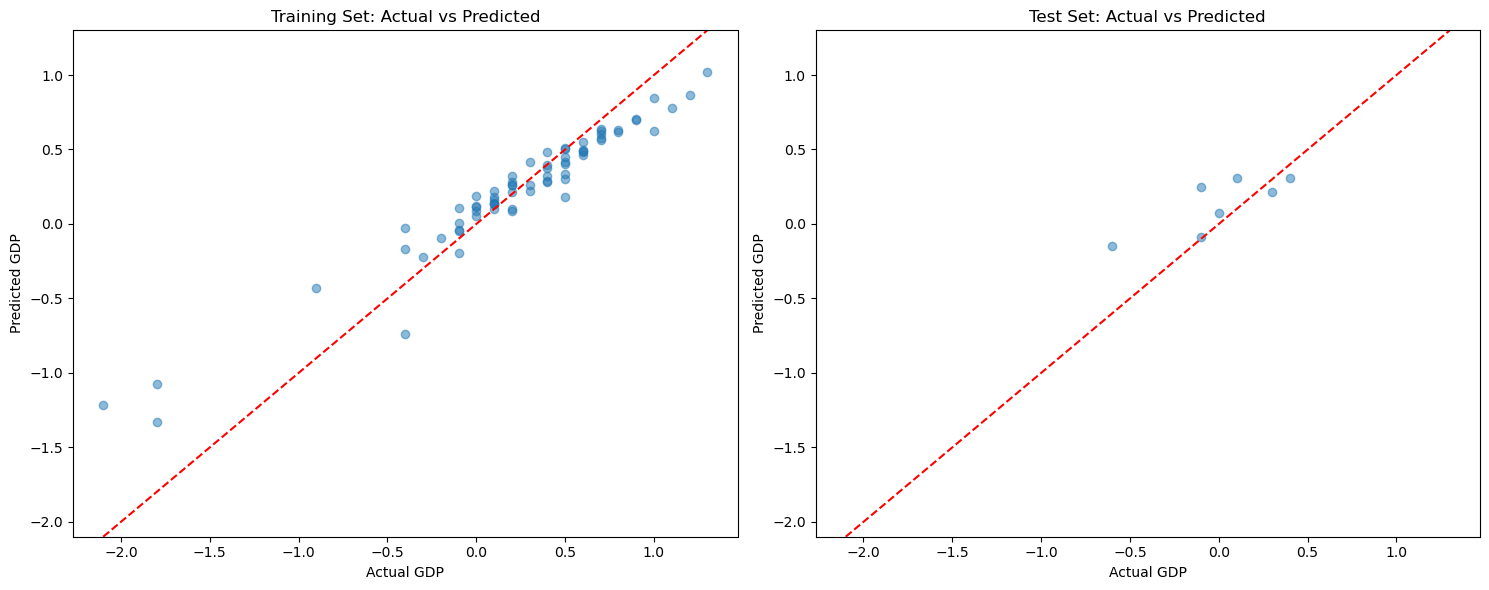

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Assuming X_train_selected, y_train, X_test_selected, y_test are defined elsewhere
# Train the Random Forest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_selected, y_train)

# Predict on the training and test sets
y_train_pred = random_forest_model.predict(X_train_selected)
y_test_pred = random_forest_model.predict(X_test_selected)

# Determine y-axis limits based on training set predictions
y_min = min(min(y_train), min(y_train_pred))
y_max = max(max(y_train), max(y_train_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Training set plot
ax[0].scatter(y_train, y_train_pred, alpha=0.5)
ax[0].plot([y_min, y_max], [y_min, y_max], 'r--')
ax[0].set_title('Training Set: Actual vs Predicted')
ax[0].set_xlabel('Actual GDP')
ax[0].set_ylabel('Predicted GDP')
ax[0].set_ylim(y_min, y_max)

# Test set plot
ax[1].scatter(y_test, y_test_pred, alpha=0.5)
ax[1].plot([y_min, y_max], [y_min, y_max], 'r--')
ax[1].set_title('Test Set: Actual vs Predicted')
ax[1].set_xlabel('Actual GDP')
ax[1].set_ylabel('Predicted GDP')
ax[1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [48]:
# deep learning models
# Convert DataFrame to NumPy array and then to PyTorch Tensor
X_train_tensor = torch.tensor(X_train_selected.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
X_val_tensor = torch.tensor(X_val_selected.values.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).view(-1, 1)
X_test_tensor = torch.tensor(X_test_selected.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Continue with creating Tensor datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 50, Finished, Available, Finished)

In [49]:
def evaluate_model(model, val_loader, test_loader, device):
    model.to(device)
    model.eval()

    def calculate_metrics(predictions, targets):
        mse = mean_squared_error(targets, predictions)
        rmse = sqrt(mse)
        mae = mean_absolute_error(targets, predictions)
        return mse, rmse, mae

    val_preds, val_targets = [], []
    test_preds, test_targets = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_preds.extend(output.view(-1).tolist())
            val_targets.extend(target.view(-1).tolist())

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_preds.extend(output.view(-1).tolist())
            test_targets.extend(target.view(-1).tolist())

    val_mse, val_rmse, val_mae = calculate_metrics(val_preds, val_targets)
    test_mse, test_rmse, test_mae = calculate_metrics(test_preds, test_targets)

    return val_mse, val_rmse, val_mae, test_mse, test_rmse, test_mae

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 51, Finished, Available, Finished)

In [50]:
# define models. 
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output_layer(x)
        return x

class ConvNet(nn.Module):
    def __init__(self, input_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * input_size, 64)  # Assuming the input has been flattened
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Assuming x has shape [batch, input_size]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Assuming x has shape [batch, input_size], add sequence length
        x, (hn, cn) = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last timestep
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
        )
        self.fc = nn.Linear(input_size, 1)  # Regression layer after decoding
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.fc(decoded)
        return output

class TransformerNet(nn.Module):
    def __init__(self, input_size, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerNet, self).__init__()
        # Adjust the input_size to be divisible by nhead
        self.adjusted_size = (input_size // nhead + (input_size % nhead != 0)) * nhead
        
        # Initial linear layer to adjust input dimensionality
        self.adjust_input = nn.Linear(input_size, self.adjusted_size)

        # Transformer model setup
        self.transformer = nn.Transformer(
            d_model=self.adjusted_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True  # Make sure the input is (batch_size, sequence_length, input_size)
        )

        # Final linear layer to predict a single output value
        self.fc_out = nn.Linear(self.adjusted_size, 1)

    def forward(self, x):
        # Add sequence length dimension (assuming x has shape [batch_size, input_size])
        x = x.unsqueeze(1)

        # Adjust the input dimensionality to match the transformer's requirement
        x = self.adjust_input(x)

        # Transformer processing
        x = self.transformer(x, x)

        # Take output from the last sequence step
        x = x[:, -1, :]  # Assuming that we are only interested in the output of the last step

        # Final output layer
        output = self.fc_out(x)
        return output

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 52, Finished, Available, Finished)

In [51]:
# model assessment 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_registry = {
    'FullyConnectedNet': lambda: FullyConnectedNet(input_size=X_train_selected.shape[1]),
    'ConvNet': lambda: ConvNet(input_size=X_train_selected.shape[1]),
    'LSTMNet': lambda: LSTMNet(input_size=X_train_selected.shape[1], hidden_dim=64, num_layers=2),  # Example values
    'Autoencoder': lambda: Autoencoder(input_size=X_train_selected.shape[1]),
    'TransformerNet': lambda: TransformerNet(input_size=X_train_selected.shape[1], nhead=8, num_encoder_layers=3, dim_feedforward=2048)  # Example values
}


StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 53, Finished, Available, Finished)

In [53]:
def train_model(model, train_loader, val_loader, test_loader, device, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.to(device)

    all_train_mse = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_preds, train_targets = [], []
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_preds.extend(output.view(-1).detach().cpu().numpy())
            train_targets.extend(target.view(-1).detach().cpu().numpy())

        # Calculate training metrics
        train_mse = mean_squared_error(train_targets, train_preds)
        train_rmse = sqrt(train_mse)
        train_mae = mean_absolute_error(train_targets, train_preds)
        all_train_mse.append(train_mse)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Train MSE: {train_mse}, Validation Loss: {val_loss/len(val_loader)}')

    # Final metrics after all epochs
    train_mse = np.mean(all_train_mse)
    train_rmse = sqrt(train_mse)
    train_mae = mean_absolute_error(train_targets, train_preds)

    # Evaluation after training
    val_mse, val_rmse, val_mae, test_mse, test_rmse, test_mae = evaluate_model(model, val_loader, test_loader, device)
    return train_mse, train_rmse, train_mae, val_mse, val_rmse, val_mae, test_mse, test_rmse, test_mae

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 55, Finished, Available, Finished)

In [54]:
results = {}
for name, create_model in model_registry.items():
    print(f"Evaluating {name}...")
    model = create_model()
    train_mse, train_rmse, train_mae, val_mse, val_rmse, val_mae, test_mse, test_rmse, test_mae = train_model(model, train_loader, val_loader, test_loader, device, num_epochs=50)
    results[name] = {
        'Train MSE': train_mse,
        'Train RMSE': train_rmse,
        'Train MAE': train_mae,
        'Validation MSE': val_mse,
        'Validation RMSE': val_rmse,
        'Validation MAE': val_mae,
        'Test MSE': test_mse,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae
    }

# Display formatted results
results_df = pd.DataFrame(results).T
formatted_results_df = results_df.apply(lambda col: col.map(lambda x: f'{x:.3f}'))
print(formatted_results_df)

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 56, Finished, Available, Finished)

Evaluating FullyConnectedNet...
Epoch 1/50, Train Loss: 802773216.0, Train MSE: 822668736.0, Validation Loss: 746775296.0
Epoch 2/50, Train Loss: 427737014.0, Train MSE: 711095104.0, Validation Loss: 130011248.0
Epoch 3/50, Train Loss: 341699256.0, Train MSE: 187999600.0, Validation Loss: 263818208.0
Epoch 4/50, Train Loss: 165879394.0, Train MSE: 267165984.0, Validation Loss: 37892496.0
Epoch 5/50, Train Loss: 125274204.0, Train MSE: 56948252.0, Validation Loss: 221957424.0
Epoch 6/50, Train Loss: 173166216.0, Train MSE: 216767744.0, Validation Loss: 8118098.5
Epoch 7/50, Train Loss: 19290208.5, Train MSE: 9944759.0, Validation Loss: 107716024.0
Epoch 8/50, Train Loss: 121946696.0, Train MSE: 124072760.0, Validation Loss: 71828696.0
Epoch 9/50, Train Loss: 46985038.0, Train MSE: 75751272.0, Validation Loss: 9132019.0
Epoch 10/50, Train Loss: 29989247.0, Train MSE: 12984504.0, Validation Loss: 80048216.0
Epoch 11/50, Train Loss: 69071074.0, Train MSE: 78404144.0, Validation Loss: 16072

StatementMeta(, d138c4b2-ef42-4bb3-bbd2-9c0402ad9c61, 57, Finished, Available, Finished)

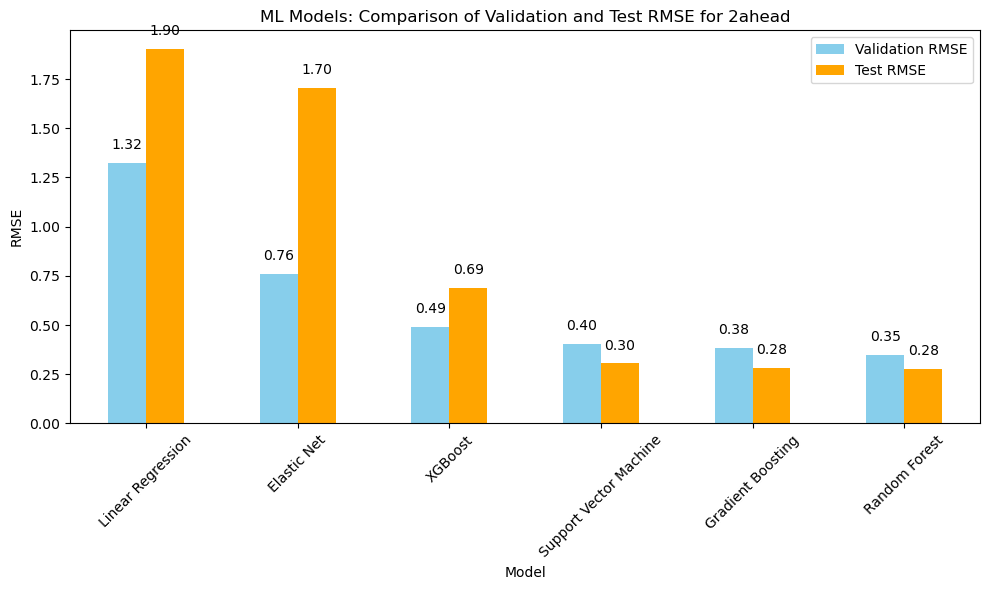

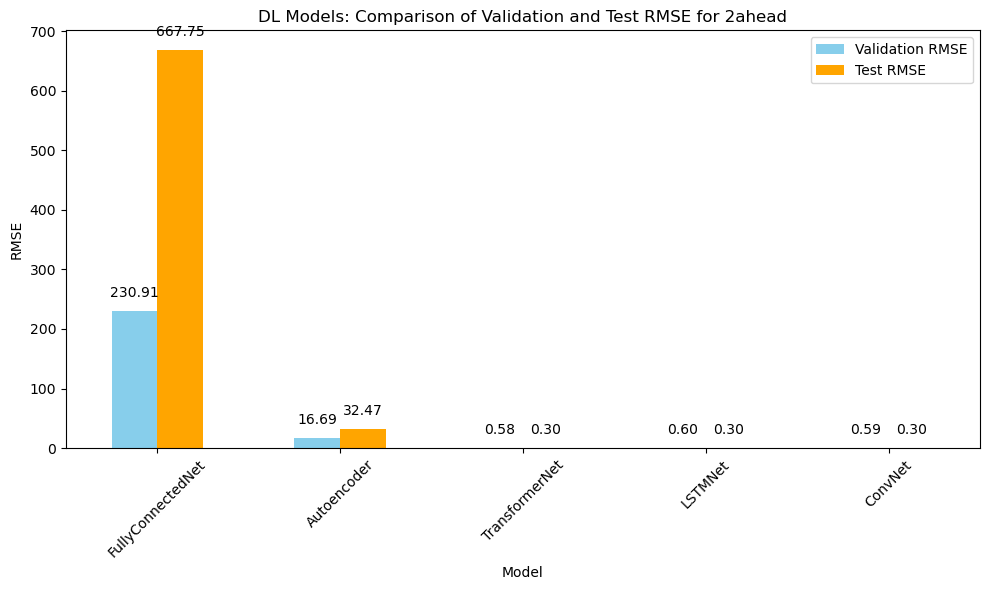

In [55]:
# bar plot 
def add_labels(ax, spacing=10):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        label = "{:.2f}".format(y_value)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            textcoords="offset points", 
            xytext=(0, spacing),        
            ha='center')                

# sorted df by Test RMSE 
rmse_df_sorted = rmse_df.sort_values('Test RMSE', ascending=False)
dl_sorted = formatted_results_df.apply(pd.to_numeric, errors='coerce').sort_values('Test RMSE', ascending=False)

# ML bar plot 
fig, ax = plt.subplots(figsize=(10, 6))
rmse_df_sorted[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('ML Models: Comparison of Validation and Test RMSE for 2ahead')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(rmse_df_sorted.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()

plt.show()

# DL bar plot 
fig, ax = plt.subplots(figsize=(10, 6))
dl_sorted[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('DL Models: Comparison of Validation and Test RMSE for 2ahead')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(dl_sorted.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()

plt.show()

## Old

In [ ]:
# Define a dictionary of models to train including additional models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Machine": SVR(),
    "Elastic Net": ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train each model on selected features and evaluate
for name, model in models.items():
    # Train the model
    model.fit(X_train_selected, y_train)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_selected)
    
    # Evaluate on validation set
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    print(f"{name} Validation MSE: {val_mse}")
    print(f"{name} Validation RMSE: {val_rmse}")
    print(f"{name} Validation MAE: {val_mae}")

    # Predict on test set and evaluate
    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    print(f"{name} Test MSE: {test_mse}")
    print(f"{name} Test RMSE: {test_rmse}")
    print(f"{name} Test MAE: {test_mae}\n")

StatementMeta(, 1cfdc114-4226-471f-bc22-52d4bec52f04, 39, Finished, Available, Finished)

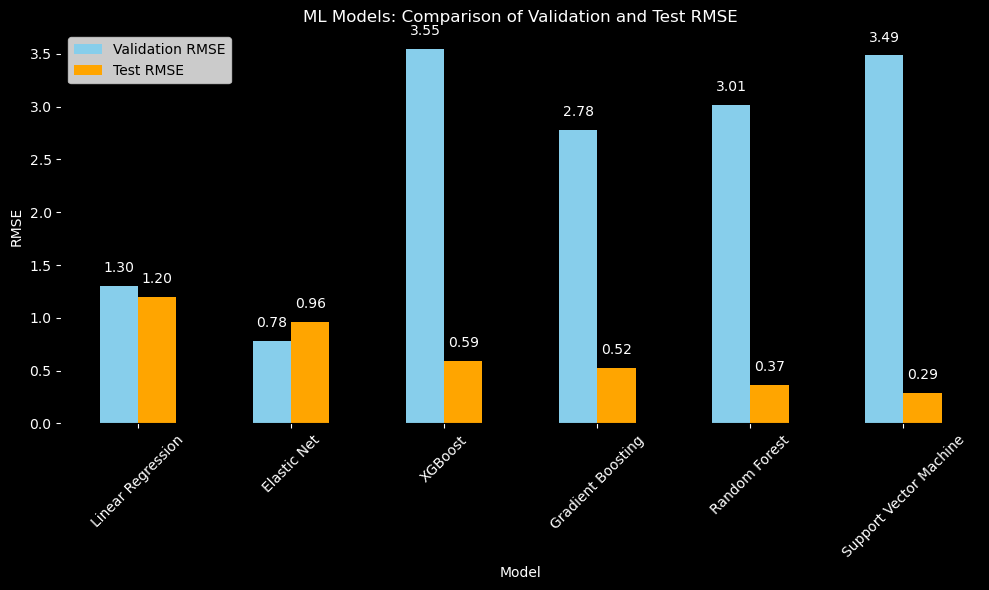

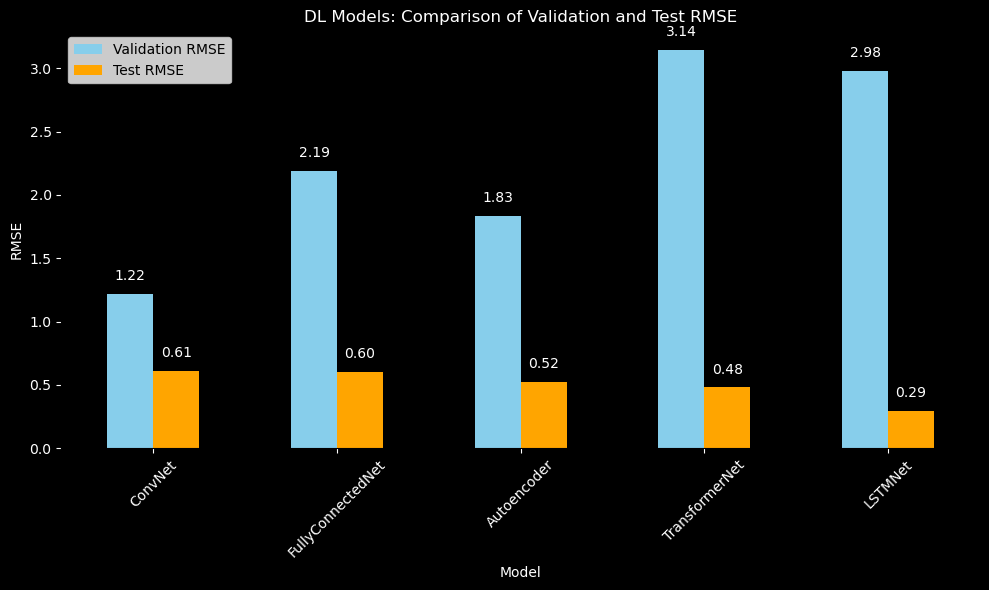

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def add_labels(ax, spacing=10):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        label = "{:.2f}".format(y_value)
        ax.annotate(
            label,
            (x_value, y_value),
            textcoords="offset points",
            xytext=(0, spacing),
            ha='center',
            color='white')  # Text color

# Assuming 'rmse_df' and 'formatted_results_df' are defined elsewhere in your script
rmse_df_sorted = rmse_df.sort_values('Test RMSE', ascending=False)
dl_sorted = formatted_results_df.apply(pd.to_numeric, errors='coerce').sort_values('Test RMSE', ascending=False)

# ML bar plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')  # Background color
fig.patch.set_facecolor('black')  # Background color for the figure canvas
rmse_df_sorted[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('ML Models: Comparison of Validation and Test RMSE', color='white')
ax.set_xlabel('Model', color='white')
ax.set_ylabel('RMSE', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_xticklabels(rmse_df_sorted.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()

plt.show()

# DL bar plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')  # Background color
fig.patch.set_facecolor('black')  # Background color for the figure canvas
dl_sorted[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('DL Models: Comparison of Validation and Test RMSE', color='white')
ax.set_xlabel('Model', color='white')
ax.set_ylabel('RMSE', color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_xticklabels(dl_sorted.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()

plt.show()

StatementMeta(, 1cfdc114-4226-471f-bc22-52d4bec52f04, 19, Finished, Available, Finished)

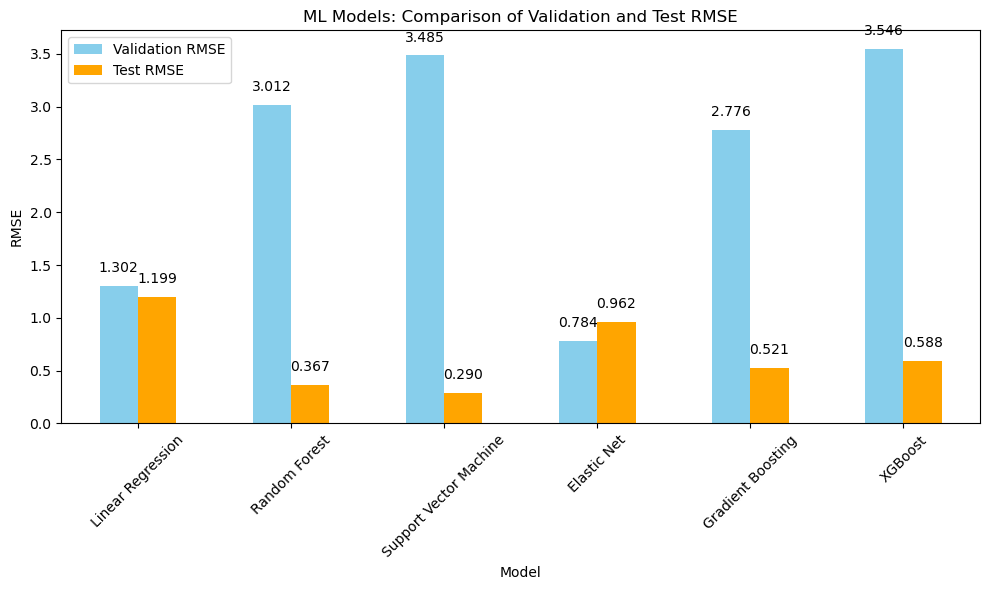

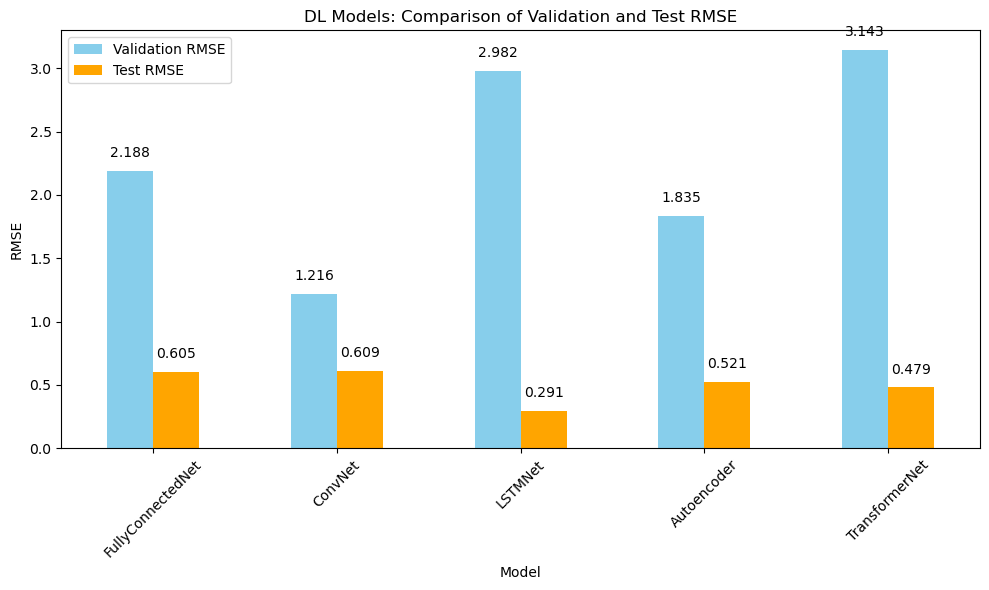

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 rmse_df 和 formatted_results_df 已经正确加载，且包含所需数据
# 示例数据结构：
# rmse_df 数据结构（ML 模型）
#                         Validation RMSE  Test RMSE
# Linear Regression             1.302394    1.198646
# Random Forest                 3.012212    0.367078
# ...                           ...         ...

# formatted_results_df 数据结构（DL 模型）
#                         Validation RMSE  Test RMSE
# FullyConnectedNet           0.802        0.789
# ConvNet                      0.456        0.432
# ...                           ...         ...

# 函数用于添加标签
def add_labels(ax, spacing=10):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        label = "{:.3f}".format(y_value)
        ax.annotate(
            label,                      # 使用 .format 格式化标签
            (x_value, y_value),         # 将标签放在条形中间的上方
            textcoords="offset points", # 文字位置以点为单位
            xytext=(0, spacing),        # 文字偏移
            ha='center')                # 水平居中

# ML 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
rmse_df[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('ML Models: Comparison of Validation and Test RMSE')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.xticks(rotation=45)
plt.tight_layout()

# 显示 ML 模型的图
plt.show()

# DL 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
dl_rmse = formatted_results_df[['Validation RMSE', 'Test RMSE']].apply(pd.to_numeric, errors='coerce')  # 确保数据类型为数值型
dl_rmse.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('DL Models: Comparison of Validation and Test RMSE')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.xticks(rotation=45)
plt.tight_layout()

# 显示 DL 模型的图
plt.show()

StatementMeta(, 1cfdc114-4226-471f-bc22-52d4bec52f04, 27, Finished, Available, Finished)

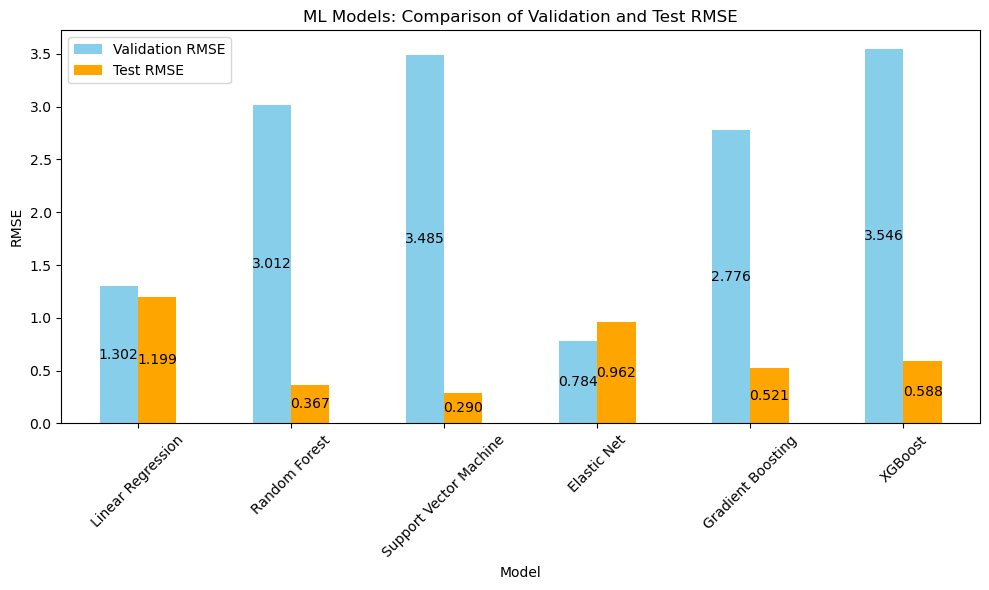

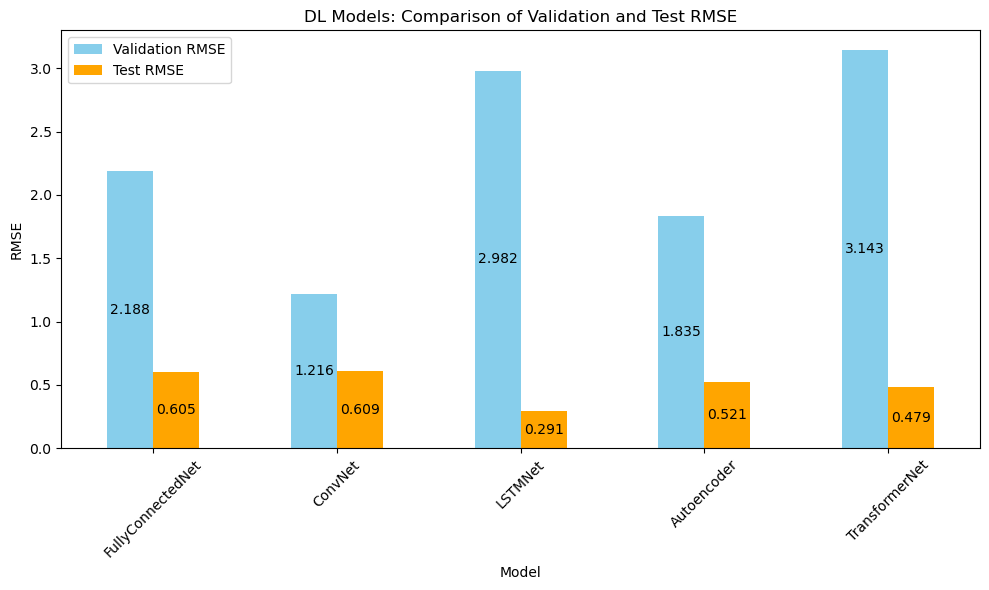

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 rmse_df 和 formatted_results_df 已经正确加载，且包含所需数据
# 示例数据结构：
# rmse_df 数据结构（ML 模型）
#                         Validation RMSE  Test RMSE
# Linear Regression             1.302394    1.198646
# Random Forest                 3.012212    0.367078
# ...                           ...         ...

# formatted_results_df 数据结构（DL 模型）
#                         Validation RMSE  Test RMSE
# FullyConnectedNet           0.802        0.789
# ConvNet                      0.456        0.432
# ...                           ...         ...

# 函数用于添加标签，标签位于条形的中间
def add_labels(ax, spacing=10):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        label = "{:.3f}".format(y_value)
        ax.annotate(
            label,                      # 使用 .format 格式化标签
            (x_value, y_value / 2),     # 将标签放在条形中间
            textcoords="offset points", # 文字位置以点为单位
            xytext=(0, 0),              # 无偏移
            ha='center',                # 水平居中
            va='center')                # 垂直居中

# ML 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
rmse_df[['Validation RMSE', 'Test RMSE']].plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('ML Models: Comparison of Validation and Test RMSE')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(rmse_df.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()
# 显示 ML 模型的图
plt.show()

# DL 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
dl_sorted = formatted_results_df[['Validation RMSE', 'Test RMSE']].apply(pd.to_numeric, errors='coerce')
dl_sorted.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
add_labels(ax)
ax.set_title('DL Models: Comparison of Validation and Test RMSE')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_xticklabels(dl_sorted.index, rotation=45)
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.tight_layout()
# 显示 DL 模型的图
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 rmse_df 和 formatted_results_df 已经正确加载，且包含所需数据
# 示例数据结构：
# rmse_df 数据结构（ML 模型）
#                         Validation RMSE  Test RMSE
# Linear Regression             1.302394    1.198646
# Random Forest                 3.012212    0.367078
# ...                           ...         ...

# formatted_results_df 数据结构（DL 模型）
#                         Validation RMSE  Test RMSE
# FullyConnectedNet           0.802        0.789
# ConvNet                      0.456        0.432
# ...                           ...         ...

# 函数用于添加标签，标签位于条形的中间
def add_labels(ax, spacing=10):
    for bar in ax.patches:
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2
        label = "{:.3f}".format(y_value)
        ax.annotate(
            label,                      # 使用 .format 格式化标签
            (x_value, y_value / 2),     # 将标签放在条形中间
            textcoords="offset points", # 文字位置以点为单位
            xytext=(0, 0),              # 无偏移
            ha='center',                # 水平居中
            va='center')                # 垂直居中

# 按照 Test RMSE 降序排列数据
rmse_df_sorted = rmse_df.sort_values('Test RMSE', ascending=False)
dl_sorted = formatted_results_df.apply(pd.to_numeric, errors='coerce').sort_values('Test RMSE', ascending=False)

# ML 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
rmse_df_sorted['Test RMSE'].plot(kind='bar', ax=ax, color='orange')
add_labels(ax)
ax.set_title('ML Models: Test RMSE')
ax.set_xlabel('Model')
ax.set_ylabel('Test RMSE')
ax.set_xticklabels(rmse_df_sorted.index, rotation=45)
plt.tight_layout()
# 显示 ML 模型的图
plt.show()

# DL 模型的条形图
fig, ax = plt.subplots(figsize=(10, 6))
dl_sorted['Test RMSE'].plot(kind='bar', ax=ax

StatementMeta(, 1cfdc114-4226-471f-bc22-52d4bec52f04, 28, Finished, Available, Finished)

SyntaxError: incomplete input (1968772332.py, line 50)

StatementMeta(, 1cfdc114-4226-471f-bc22-52d4bec52f04, 17, Finished, Available, Finished)

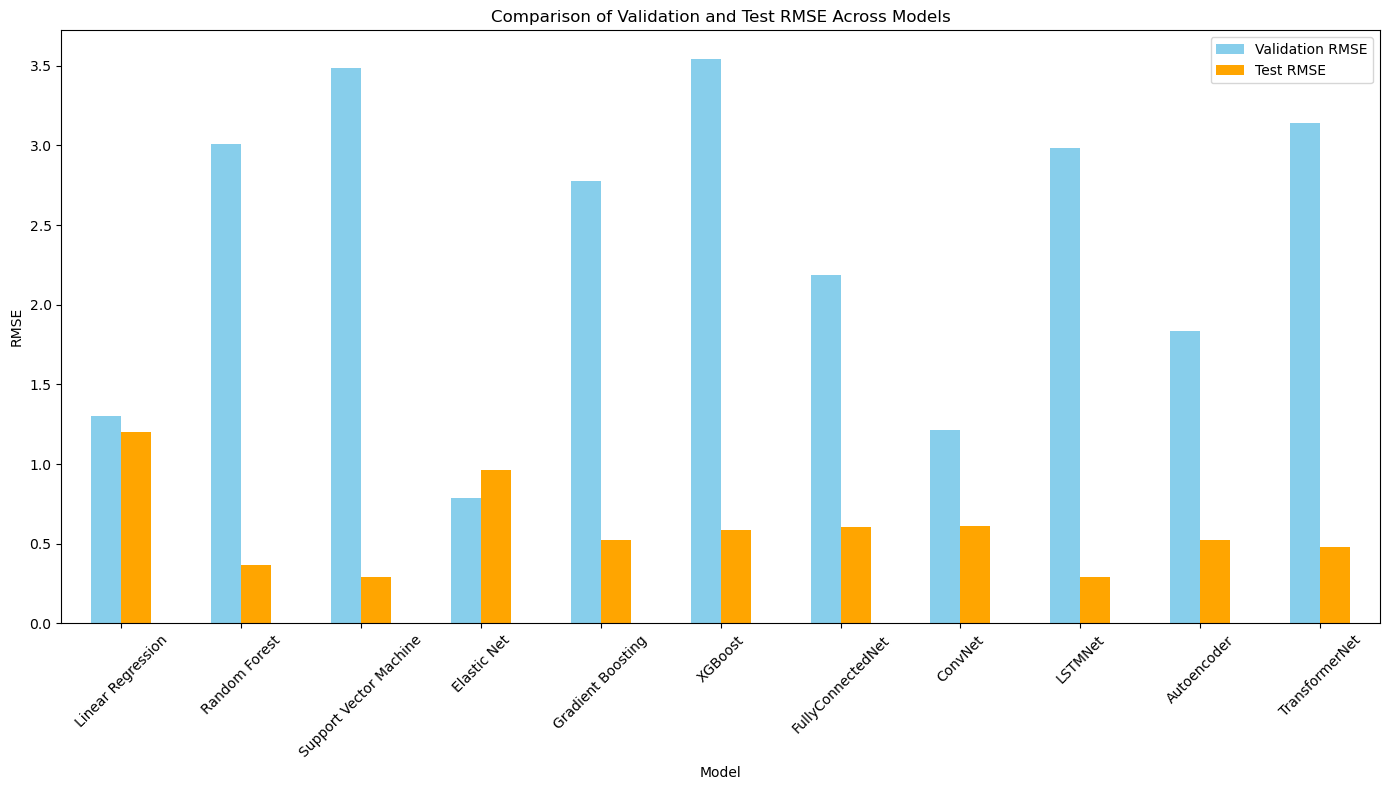

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 rmse_df 和 formatted_results_df 已经正确加载，且包含所需数据
# 示例数据结构：
# rmse_df 数据结构
#                         Validation RMSE  Test RMSE
# Linear Regression             1.302394    1.198646
# Random Forest                 3.012212    0.367078
# ...                           ...         ...

# formatted_results_df 数据结构
#                         Validation RMSE  Test RMSE
# FullyConnectedNet           0.802        0.789
# ConvNet                      0.456        0.432
# ...                           ...         ...

# 提取 RMSE 数据
ml_rmse = rmse_df[['Validation RMSE', 'Test RMSE']]
dl_rmse = formatted_results_df[['Validation RMSE', 'Test RMSE']].apply(pd.to_numeric, errors='coerce')  # 确保数据类型为数值型

# 合并数据
combined_rmse = pd.concat([ml_rmse, dl_rmse])

# 绘制条形图
fig, ax = plt.subplots(figsize=(14, 8))
combined_rmse.plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
ax.set_title('Comparison of Validation and Test RMSE Across Models')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.legend(['Validation RMSE', 'Test RMSE'])
plt.xticks(rotation=45)
plt.tight_layout()  # 调整布局以适应标签

plt.show()

In [13]:
# model assessment 
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class ConvNet(nn.Module):
    def __init__(self, input_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * input_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度 [batch, 1, input_size]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # 展平
        return self.fc1(x)

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加时间步维度 [batch, 1, input_size]
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        return self.fc(x)

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class TransformerNet(nn.Module):
    def __init__(self, input_size, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerNet, self).__init__()
        
        # Calculate the new dimension size that is divisible by nhead
        self.adjusted_size = (input_size // nhead + (input_size % nhead != 0)) * nhead
        
        # Layer to adjust input dimensionality
        self.adjust_input = nn.Linear(input_size, self.adjusted_size)
        
        # Transformer model
        self.transformer = nn.Transformer(
            d_model=self.adjusted_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            batch_first=True  # Assume input of shape (batch_size, sequence_length, feature_size)
        )
        
        # Output linear layer
        self.fc_out = nn.Linear(self.adjusted_size, 1)
    
    def forward(self, x):
        # Adjust the input dimensionality
        x = self.adjust_input(x.unsqueeze(1))  # Unsqueeze to add sequence length dimension
        
        # Apply the Transformer
        x = self.transformer(x, x)
        
        # Take output from the last sequence step
        x = x[:, -1, :]
        
        # Pass through the output layer
        return self.fc_out(x)

model_registry = {
    'FullyConnectedNet': FullyConnectedNet,
    'ConvNet': ConvNet,
    'LSTMNet': LSTMNet,
    'Autoencoder': Autoencoder,
    'TransformerNet': TransformerNet
}

# initialize the model
def initialize_model(model_name, input_size, **kwargs):
    model_class = model_registry.get(model_name)
    if model_class is None:
        raise ValueError(f"Model name '{model_name}' is not recognized.")
    return model_class(input_size, **kwargs)

# train function
def train(train_loader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # return total_loss / len(train_loader)
    return math.sqrt(total_loss / len(train_loader)) # RMSE 

# validation function
def validate(val_loader, model, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            total_loss += loss.item()
    # return total_loss / len(val_loader)
    return math.sqrt(total_loss / len(val_loader)) # RMSE 

# run the model 
def run_model(model_name, input_size, train_loader, val_loader, epochs=50, **kwargs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = initialize_model(model_name, input_size, **kwargs).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train(train_loader, model, loss_fn, optimizer,device)
        val_loss = validate(val_loader, model, loss_fn,device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Validation Loss {val_loss:.4f}")

    return train_losses, val_losses

# 使用你的数据
# 假设 X_train_selected, y_train, X_val_selected, y_val 是你的数据
# 将数据转换为 PyTorch 张量
# X_train_tensor = torch.tensor(X_train_selected.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_val_tensor = torch.tensor(X_val_selected.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# build DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# run all dl models 
input_size = X_train_selected.shape[1] 
results = {}

for model_name in model_registry.keys():
    print(f"Training {model_name}...")
    if model_name == 'LSTMNet':
        train_losses, val_losses = run_model(model_name, input_size, train_loader, val_loader, hidden_dim=64)
    elif model_name == 'TransformerNet':
        train_losses, val_losses = run_model(model_name, input_size, train_loader, val_loader, nhead=2, num_encoder_layers=2, dim_feedforward=128)
    else:
        train_losses, val_losses = run_model(model_name, input_size, train_loader, val_loader)
    results[model_name] = {'train_losses': train_losses, 'val_losses': val_losses}

for model_name, result in results.items():
    print(f"{model_name}: Final Train Loss {result['train_losses'][-1]:.4f}, Final Validation Loss {result['val_losses'][-1]:.4f}")

StatementMeta(, 155aac31-d9ca-4ce9-9e42-bdefdbd30cf8, 15, Finished, Available, Finished)

Training FullyConnectedNet...
Epoch 1: Train Loss 2.0495, Validation Loss 2.5648
Epoch 2: Train Loss 1.7617, Validation Loss 2.5082
Epoch 3: Train Loss 1.6437, Validation Loss 2.4307
Epoch 4: Train Loss 1.3716, Validation Loss 2.0558
Epoch 5: Train Loss 1.1623, Validation Loss 1.8437
Epoch 6: Train Loss 1.9212, Validation Loss 1.7136
Epoch 7: Train Loss 1.0408, Validation Loss 1.7266
Epoch 8: Train Loss 0.8950, Validation Loss 1.7495
Epoch 9: Train Loss 0.9467, Validation Loss 1.5375
Epoch 10: Train Loss 0.7498, Validation Loss 1.3382
Epoch 11: Train Loss 0.7256, Validation Loss 1.3027
Epoch 12: Train Loss 0.8021, Validation Loss 1.2817
Epoch 13: Train Loss 0.6878, Validation Loss 1.3566
Epoch 14: Train Loss 0.6588, Validation Loss 1.4590
Epoch 15: Train Loss 0.8141, Validation Loss 1.4327
Epoch 16: Train Loss 0.6221, Validation Loss 1.4094
Epoch 17: Train Loss 0.5896, Validation Loss 1.4634
Epoch 18: Train Loss 0.7058, Validation Loss 1.5384
Epoch 19: Train Loss 0.6282, Validation Los

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Initialize the model
model = NeuralNetwork(X_train_selected.shape[1])

StatementMeta(, f501530b-8916-4e20-a65b-4b67d1c23c41, 11, Finished, Available, Finished)

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 52, Finished, Available, Finished)

Epoch 1
-------------------------------
Validation RMSE: 1.0463
Epoch 2
-------------------------------
Validation RMSE: 1.4811
Epoch 3
-------------------------------
Validation RMSE: 1.3402
Epoch 4
-------------------------------
Validation RMSE: 1.1069
Epoch 5
-------------------------------
Validation RMSE: 1.0747
Epoch 6
-------------------------------
Validation RMSE: 1.0313
Epoch 7
-------------------------------
Validation RMSE: 1.0924
Epoch 8
-------------------------------
Validation RMSE: 1.1846
Epoch 9
-------------------------------
Validation RMSE: 1.1018
Epoch 10
-------------------------------
Validation RMSE: 0.9991
Epoch 11
-------------------------------
Validation RMSE: 1.0029
Epoch 12
-------------------------------
Validation RMSE: 1.0677
Epoch 13
-------------------------------
Validation RMSE: 1.1834
Epoch 14
-------------------------------
Validation RMSE: 1.2727
Epoch 15
-------------------------------
Validation RMSE: 1.2783
Epoch 16
-------------------------

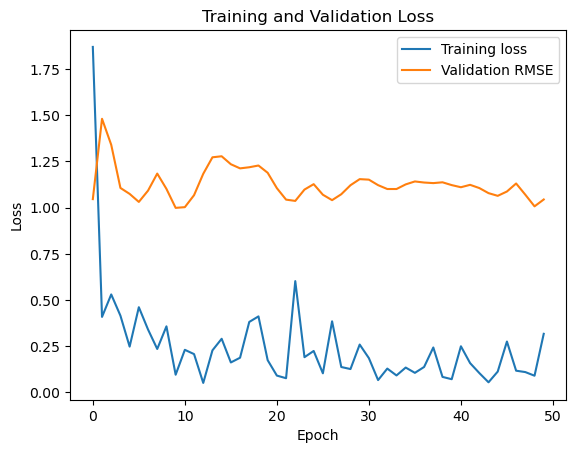

In [50]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, current = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
    loss /= num_batches
    return np.sqrt(loss)  # Return RMSE

# Record losses for plotting
train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    val_loss = validate(val_loader, model, loss_fn)
    print(f"Validation RMSE: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [46]:
# old version
# # Loss function
# loss_fn = nn.MSELoss()  # Mean Squared Error Loss

# # Optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 48, Finished, Available, Finished)

In [52]:
# first definition
# Assuming data preparation is completed as per previous instructions

# class FullyConnectedNet(nn.Module):
#     def __init__(self, input_size):
#         super(FullyConnectedNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 1)
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         return self.fc3(x)

# class ConvNet(nn.Module):
#     def __init__(self, input_size):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)  # Input channels = 1, output channels = 32
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)  # Input channels = 32, output channels = 64
#         # Assuming the sequence length stays the same through convolutions due to padding
#         self.fc1 = nn.Linear(64 * input_size, 1)  # Adjust this if there's any pooling
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
#         return self.fc1(x)

# class LSTMNet(nn.Module):
#     def __init__(self, input_size, hidden_dim, num_layers=1):
#         super(LSTMNet, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, 1)
    
#     def forward(self, x):
#         x, (hn, cn) = self.lstm(x)
#         x = x[:, -1, :]  # Take only the last output
#         return self.fc(x)

# class Autoencoder(nn.Module):
#     def __init__(self, input_size):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(16, 32),
#             nn.ReLU(),
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, input_size),
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# class TransformerNet(nn.Module):
#     def __init__(self, input_size, nhead, num_encoder_layers, dim_feedforward):
#         super(TransformerNet, self).__init__()
#         self.transformer = nn.Transformer(input_size, nhead, num_encoder_layers, num_encoder_layers, dim_feedforward)
#         self.fc_out = nn.Linear(input_size, 1)
    
#     def forward(self, x):
#         x = self.transformer(x, x)
#         return self.fc_out(x[-1])

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 54, Finished, Available, Finished)

In [42]:
# old version
# def train_model(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(train_loader.dataset)
#     return epoch_loss

# def validate_model(model, val_loader, criterion, device):
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
            
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
            
#             running_loss += loss.item() * inputs.size(0)
#     epoch_loss = running_loss / len(val_loader.dataset)
#     return epoch_loss

# def run_all_models(model_classes, input_size, train_loader, val_loader, epochs=10, device='cpu'):
#     results = {}
#     for model_name, model_class in model_classes.items():
#         print(f"Training {model_name}...")
#         model = model_class(input_size).to(device)
#         optimizer = optim.Adam(model.parameters(), lr=0.001)
#         criterion = nn.MSELoss()

#         for epoch in range(epochs):
#             train_loss = train_model(model, train_loader, criterion, optimizer, device)
#             val_loss = validate_model(model, val_loader, criterion, device)
#             print(f'Epoch {epoch+1} of {epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
#         results[model_name] = val_loss
    
#     return results



StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 44, Finished, Available, Finished)

In [44]:
model_classes = {
    'FullyConnectedNet': FullyConnectedNet,
    'ConvNet': ConvNet,
    'LSTMNet': LSTMNet,
    'Autoencoder': Autoencoder,
    'TransformerNet': TransformerNet
}

input_size = X_train_selected.shape[1] 
# Call the function to run all models
results = run_all_models(model_classes, input_size, train_loader, val_loader, epochs=10, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Print results
for model_name, val_loss in results.items():
    print(f"{model_name} Validation MSE: {val_loss:.4f}")


StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 46, Finished, Available, Finished)

Training FullyConnectedNet...
Epoch 1 of 10, Train Loss: 11.1640, Val Loss: 9.2291
Epoch 2 of 10, Train Loss: 6.5481, Val Loss: 7.8988
Epoch 3 of 10, Train Loss: 6.9696, Val Loss: 5.9098
Epoch 4 of 10, Train Loss: 3.9378, Val Loss: 6.0387
Epoch 5 of 10, Train Loss: 3.2651, Val Loss: 6.0038
Epoch 6 of 10, Train Loss: 2.9070, Val Loss: 4.2667
Epoch 7 of 10, Train Loss: 2.0482, Val Loss: 2.7560
Epoch 8 of 10, Train Loss: 1.3844, Val Loss: 2.1566
Epoch 9 of 10, Train Loss: 1.3446, Val Loss: 1.8245
Epoch 10 of 10, Train Loss: 1.0966, Val Loss: 1.5141
Training LSTMNet...


TypeError: LSTMNet.__init__() missing 1 required positional argument: 'hidden_dim'

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 50, Finished, Available, Finished)

Epoch 1
-------------------------------
Validation RMSE: 2.9483
Epoch 2
-------------------------------
Validation RMSE: 2.9389
Epoch 3
-------------------------------
Validation RMSE: 2.5819
Epoch 4
-------------------------------
Validation RMSE: 2.0616
Epoch 5
-------------------------------
Validation RMSE: 1.7717
Epoch 6
-------------------------------
Validation RMSE: 1.6306
Epoch 7
-------------------------------
Validation RMSE: 1.5204
Epoch 8
-------------------------------
Validation RMSE: 1.5340
Epoch 9
-------------------------------
Validation RMSE: 1.5971
Epoch 10
-------------------------------
Validation RMSE: 1.4743
Epoch 11
-------------------------------
Validation RMSE: 1.2695
Epoch 12
-------------------------------
Validation RMSE: 1.1601
Epoch 13
-------------------------------
Validation RMSE: 1.1105
Epoch 14
-------------------------------
Validation RMSE: 1.0849
Epoch 15
-------------------------------
Validation RMSE: 1.1091
Epoch 16
-------------------------

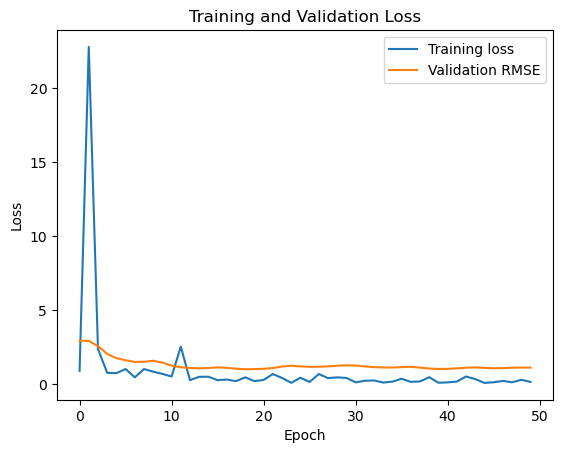

In [48]:
# this one goes well. 
# Example to initialize and use one of the models
model = FullyConnectedNet(input_size=X_train_selected.shape[1])
# Assume the rest of the setup and training loop follows the patterns shown earlier

# Loss function
loss_fn = nn.MSELoss()  # Mean Squared Error Loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.item()

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, current = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
    loss /= num_batches
    return np.sqrt(loss)  # Return RMSE

# Record losses for plotting
train_losses = []
val_losses = []

epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer)
    val_loss = validate(val_loader, model, loss_fn)
    print(f"Validation RMSE: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# Assuming X_test_selected and y_test have been converted to tensors similar to X_train_tensor and y_train_tensor
X_test_tensor = torch.tensor(X_test_selected.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# Create DataLoader for the test data
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Function to evaluate the model on the test set
def evaluate_test_set(test_loader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= len(test_loader)  # Average the loss over all batches
    return np.sqrt(test_loss)  # Return RMSE

# Calculate RMSE for the test set
test_rmse = evaluate_test_set(test_loader, model, loss_fn)
print(f"Test RMSE: {test_rmse:.4f}")

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 57, Finished, Available, Finished)

Test RMSE: 3.7656


In [54]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

class ConvNet(nn.Module):
    def __init__(self, input_size):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)  # Assuming input is reshaped [batch, channels, length]
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * input_size, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc1(x)

class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers=1):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]  # Take only the last output
        return self.fc(x)

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_size),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class TransformerNet(nn.Module):
    def __init__(self, input_size, nhead, num_encoder_layers, dim_feedforward):
        super(TransformerNet, self).__init__()
        self.transformer = nn.Transformer(input_size, nhead, num_encoder_layers, num_encoder_layers, dim_feedforward)
        self.fc_out = nn.Linear(input_size, 1)
    
    def forward(self, x):
        x = self.transformer(x, x)
        return self.fc_out(x[-1])

# Example to initialize and use one of the models
model = FullyConnectedNet(input_size=X_train_selected.shape[1])
# Assume the rest of the setup and training loop follows the patterns shown earlier

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 56, Finished, Available, Finished)

In [57]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

def initialize_model(model_name, input_size):
    if model_name == "FullyConnectedNet":
        model = FullyConnectedNet(input_size)
    # Add more elif statements for other models here
    else:
        raise ValueError("Model name not recognized")
    return model

def run_model(model_name, input_size, train_loader, val_loader, epochs=50):
    model = initialize_model(model_name, input_size)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = train(train_loader, model, loss_fn, optimizer)
        val_loss = validate(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Validation RMSE {val_loss:.4f}")

    return train_losses, val_losses

# Example of using the function
input_size = X_train_selected.shape[1]
train_losses, val_losses = run_model("FullyConnectedNet", input_size, train_loader, val_loader)

StatementMeta(, d8dcd320-d0c9-4628-9d6e-a50e5d853a6c, 59, Finished, Available, Finished)

Epoch 1: Train Loss 0.3913, Validation RMSE 2.8922
Epoch 2: Train Loss 1.5254, Validation RMSE 2.6923
Epoch 3: Train Loss 0.5836, Validation RMSE 2.1309
Epoch 4: Train Loss 0.8585, Validation RMSE 1.8685
Epoch 5: Train Loss 0.3942, Validation RMSE 1.7577
Epoch 6: Train Loss 6.4462, Validation RMSE 1.7640
Epoch 7: Train Loss 1.0118, Validation RMSE 1.7094
Epoch 8: Train Loss 0.7849, Validation RMSE 1.3945
Epoch 9: Train Loss 0.2237, Validation RMSE 1.1930
Epoch 10: Train Loss 0.7827, Validation RMSE 1.1920
Epoch 11: Train Loss 0.3217, Validation RMSE 1.3465
Epoch 12: Train Loss 0.3564, Validation RMSE 1.4993
Epoch 13: Train Loss 1.3042, Validation RMSE 1.4692
Epoch 14: Train Loss 0.5363, Validation RMSE 1.4743
Epoch 15: Train Loss 0.5273, Validation RMSE 1.5726
Epoch 16: Train Loss 0.1761, Validation RMSE 1.7165
Epoch 17: Train Loss 0.3280, Validation RMSE 1.7991
Epoch 18: Train Loss 0.2267, Validation RMSE 1.7689
Epoch 19: Train Loss 0.1520, Validation RMSE 1.7255
Epoch 20: Train Loss 

## To del

In [ ]:
df_train1 = df_current_train.copy()
df_test1 = df_current_test.copy()
df_train1 = df_train1.drop(columns=["y_lag"])
df_test1 = df_test1.drop(columns=["y_lag"])

df_train1['date'] = pd.to_datetime(df_train['date'])
df_test1['date'] = pd.to_datetime(df_test['date'])

# Shift 'y' and 'date' up by one
df_train1['y'] = df_train1['y'].shift(-1)
df_test1['y'] = df_test1['y'].shift(-1)
df_train1['date'] = df_train1['date'].shift(-1)
df_test1['date'] = df_test1['date'].shift(-1)

StatementMeta(, bf7cb113-8eea-48c6-8471-10e734db8b11, 70, Finished, Available, Finished)

In [ ]:
df_test1.columns

StatementMeta(, bf7cb113-8eea-48c6-8471-10e734db8b11, 81, Finished, Available, Finished)

Index(['date', 'y', 'cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi',
       'GBP/US', 'GBP/EU', 'unemply', 'awe', 'oil_pl', 'us_gdp', 'eu_gdp',
       'sr', 'imp', 'exp', 'expp', 'pop', 'visa', 'A_MoM', 'A_QoQ', 'B_MoM',
       'BE_MoM', 'BE_QoQ', 'C_MoM', 'C_QoQ', 'D_MoM', 'E_MoM', 'F_MoM',
       'F_QoQ', 'G_MoM', 'GT_MoM', 'GT_QoQ', 'GVA_MoM', 'H_MoM', 'I_MoM',
       'IOS_MoM', 'IOP_MoM', 'J_MoM', 'K_MoM', 'L_MoM', 'M_MoM', 'O_MoM',
       'N_MoM', 'P_MoM', 'P3G_QoQ', 'P3H_QoQ', 'P3N_QoQ', 'P51_QoQ',
       'P51S_QoQ', 'P6_QoQ', 'P7_QoQ', 'Q_MoM', 'R_MoM', 'S_MoM', 'T_MoM'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming df_train1 is already loaded
columns_to_lag = [
    'cpi', 'm4', 'm4_lend', 'loans', 'net_lend', 'br', 'gscpi',
    'GBP/US', 'GBP/EU', 'unemply', 'awe', 'oil_pl', 'us_gdp', 'eu_gdp',
    'sr', 'imp', 'exp', 'expp', 'pop', 'visa', 'A_MoM', 'A_QoQ', 'B_MoM',
    'BE_MoM', 'BE_QoQ', 'C_MoM', 'C_QoQ', 'D_MoM', 'E_MoM', 'F_MoM',
    'F_QoQ', 'G_MoM', 'GT_MoM', 'GT_QoQ', 'GVA_MoM', 'H_MoM', 'I_MoM',
    'IOS_MoM', 'IOP_MoM', 'J_MoM', 'K_MoM', 'L_MoM', 'M_MoM', 'O_MoM',
    'N_MoM', 'P_MoM', 'P3G_QoQ', 'P3H_QoQ', 'P3N_QoQ', 'P51_QoQ',
    'P51S_QoQ', 'P6_QoQ', 'P7_QoQ', 'Q_MoM', 'R_MoM', 'S_MoM', 'T_MoM'
]

# Create a new DataFrame to store lagged columns
lagged_columns = {}

for col in columns_to_lag:
    lagged_columns[f"{col}_lag1"] = df_train1[col].shift(1)  # Shift by 1 row
    lagged_columns[f"{col}_lag2"] = df_train1[col].shift(2)  # Shift by 2 rows

# Concatenate lagged columns to the original DataFrame at once (avoiding fragmentation)
df_train1 = pd.concat([df_train1, pd.DataFrame(lagged_columns)], axis=1)

# Show the updated DataFrame
print(df_train1.head(10))

StatementMeta(, bf7cb113-8eea-48c6-8471-10e734db8b11, 71, Finished, Available, Finished)

        date    y     cpi    m4  m4_lend  loans  net_lend        br     gscpi  \
0        NaT  NaN     NaN   NaN      NaN    NaN       NaN       NaN       NaN   
1 1998-03-01  0.7  70.254  10.9      8.2    NaN       NaN  7.250000 -1.073170   
2        NaT  NaN  70.498  10.7      9.3    NaN       NaN  7.250000 -0.435580   
3        NaT  NaN  70.700  10.0      8.7    NaN       NaN  7.250000 -0.060024   
4 1998-06-01  0.8  71.072  10.8      9.2    NaN       NaN  7.250000 -0.118535   
5        NaT  NaN  71.449   9.8      8.5    NaN       NaN  7.250000 -0.420967   
6        NaT  NaN  71.343   9.6      8.1    NaN       NaN  7.465909 -0.734049   
7 1998-09-01  0.7  70.952  10.4      8.7    NaN       NaN  7.500000 -0.907991   
8        NaT  NaN  71.238   9.1      8.8    NaN       NaN  7.500000 -0.877323   
9        NaT  NaN  71.548   9.4      8.8    NaN       NaN  7.500000 -0.879608   

     GBP/US  ...  P7_QoQ_lag1  P7_QoQ_lag2  Q_MoM_lag1  Q_MoM_lag2  \
0       NaN  ...          NaN         

In [ ]:
df_train1 = df_train1.dropna(subset=['date'])
df_train1.head(10)

StatementMeta(, bf7cb113-8eea-48c6-8471-10e734db8b11, 75, Finished, Available, Finished)

,date,y,cpi,m4,m4_lend,loans,net_lend,br,gscpi,GBP/US,...,P7_QoQ_lag1,P7_QoQ_lag2,Q_MoM_lag1,Q_MoM_lag2,R_MoM_lag1,R_MoM_lag2,S_MoM_lag1,S_MoM_lag2,T_MoM_lag1,T_MoM_lag2
1,1998-03-01,0.7,70.254,10.9,8.2,NaN,NaN,7.250000,-1.073170,1.635791,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1998-06-01,0.8,71.072,10.8,9.2,NaN,NaN,7.250000,-0.118535,1.673364,...,2.6,NaN,-0.2,-0.1,-3.6,-3.8,-1.1,-1.8,-2.0,-1.4
7,1998-09-01,0.7,70.952,10.4,8.7,NaN,NaN,7.500000,-0.907991,1.643657,...,2.4,NaN,-0.1,-0.2,3.8,1.6,-1.5,0.6,-2.2,-2.2
10,1998-12-01,0.9,71.534,9.4,9.2,NaN,NaN,7.306818,-0.659107,1.695200,...,0.7,NaN,0.4,0.5,-0.2,3.9,2.1,0.7,0.6,-0.4
13,1999-03-01,0.5,71.367,7.9,7.7,NaN,NaN,6.037500,-0.236580,1.651529,...,0.0,NaN,0.0,0.1,-0.2,-2.3,-2.0,4.5,-2.7,-0.7
16,1999-06-01,0.0,72.168,7.8,7.6,5931.0,NaN,5.287500,-0.199259,1.610014,...,3.1,NaN,-0.5,-0.4,1.7,0.9,-1.1,-1.1,2.9,-0.8
19,1999-09-01,1.7,71.877,3.8,6.6,5034.0,NaN,5.000000,-0.599134,1.574732,...,1.2,NaN,0.1,-0.3,-0.1,0.9,0.3,2.0,0.1,3.1
22,1999-12-01,1.3,72.330,3.5,7.2,6113.0,NaN,5.250000,-0.118249,1.657176,...,3.6,NaN,0.1,0.3,-0.7,-0.7,-6.2,-1.3,5.7,1.7
25,2000-03-01,0.8,71.936,3.2,8.5,7732.0,NaN,5.654762,-0.595201,1.638852,...,1.9,NaN,-0.1,-0.1,0.7,2.0,1.2,-2.0,-4.9,2.0
28,2000-06-01,0.5,72.573,5.2,10.3,9215.0,NaN,6.000000,0.142039,1.583375,...,1.3,NaN,0.6,0.3,0.1,-0.1,1.4,0.0,4.7,-3.1


In [ ]:
selected_columns = df_train1[['date', 'y','cpi', 'cpi_lag1', 'cpi_lag2']]
selected_columns.head(10)

StatementMeta(, bf7cb113-8eea-48c6-8471-10e734db8b11, 77, Finished, Available, Finished)

,date,y,cpi,cpi_lag1,cpi_lag2
1,1998-03-01,0.7,70.254,NaN,NaN
4,1998-06-01,0.8,71.072,70.700,70.498
7,1998-09-01,0.7,70.952,71.343,71.449
10,1998-12-01,0.9,71.534,71.548,71.238
13,1999-03-01,0.5,71.367,71.808,71.590
16,1999-06-01,0.0,72.168,71.880,71.489
19,1999-09-01,1.7,71.877,72.306,72.382
22,1999-12-01,1.3,72.330,72.387,72.097
25,2000-03-01,0.8,71.936,72.615,72.435
28,2000-06-01,0.5,72.573,72.338,72.159


## Results